#### Notebook Author

**Nasirudeen Raheem**

**Note**

* The workflow here is the extracted clean data from Hack_Feed_Solution_1 Notebook

* Titled - Post_data.csv

## Hack The Feed: Insights From Social Media Data

In this notebook, we are able to implement the following solution:


1. Data Insights for Business

2. Topic Modelling

3. Word Cloud and Text Analytics

4. Machine Learning Application

5. Interpretable Machine Learning

## Introduction

This is the application of text analytics to the post of the clients, in this Text Analytics we are going to use two major techniques in finding insight from the data. which are:

### 1. Topic Modelling - Unsupervised machine learning (Clustering task)

Topic Modelling is a techniques for categorizing content into most common words, this is useful to know what the brand content creator having post over the past 10 years.

**The Benefit of Topic Modelling are:**

* Content Summarization: Topic modeling provides a high-level view of themes present in a large collection of posts, helping users quickly understand the primary subjects without having to read each post in detail.

* Content Categorization: For websites or platforms with vast amounts of content, topic modeling can help automatically categorize and tag content, making content management more efficient.

### 2. Classifying the post sentiment - Supervised Machine Learning Techniques

A machine Learning model to classify the post sentiment before posting will assist the client, in having a good public relations that will boost their brand image across different social media platform.

**The Benefit of the Machine Learning models are:**

* Automation Review - This will assist the content creator in knowing the actual tone used in constructing their content before posting to the public.

* Brand Image - The machine learning model will mitigate the risk of the brand for having bad image that may arises due to Human Error, and it will maintain the brand positive reputation.

* Crisis Management - Early detection of negative sentiment will help the client anticipate potential crises and manage them proactively.

### Visualization Libraries

In [174]:
#!pip install shap

In [175]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import os



### Text Analytics Libraries

In [176]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
import wordcloud
from wordcloud import WordCloud
import string

import itertools
import collections
from collections import Counter

import nltk
#import contractions
import re

## For Entity Recognition
import spacy

## for feature extraction

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Machine Learning Libraries

In [177]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
## machine learning libary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier


# importing the libraries
import shap

### Working with the data

In [178]:
data = pd.read_csv('Post_data.csv')

In [179]:
data.head()

,Post,sentiment_label,Network,Engagements
0,"We celebrated recently with Novare, one of our...",Positive sentiment,Facebook,1024
1,N5k can get you started today. Call 01 280 126...,Neutral sentiment,Facebook,5876
2,Still not sure whether to invest in the FGN Bo...,Negative sentiment,Facebook,4744
3,Let nothing stop you from achieving your goals...,Positive sentiment,Facebook,445
4,"If you were to pick one wish, what would it be...",Positive sentiment,Facebook,4730


In [180]:
data.groupby('Network')['Engagements'].agg(['mean', 'sum']).reset_index()

,Network,mean,sum
0,Facebook,231.461055,2023664
1,Instagram,100.519071,1004085
2,LinkedIn,49.800794,313745
3,Twitter,110.073706,863198


### Quanity and Quality Engagement per each social media network

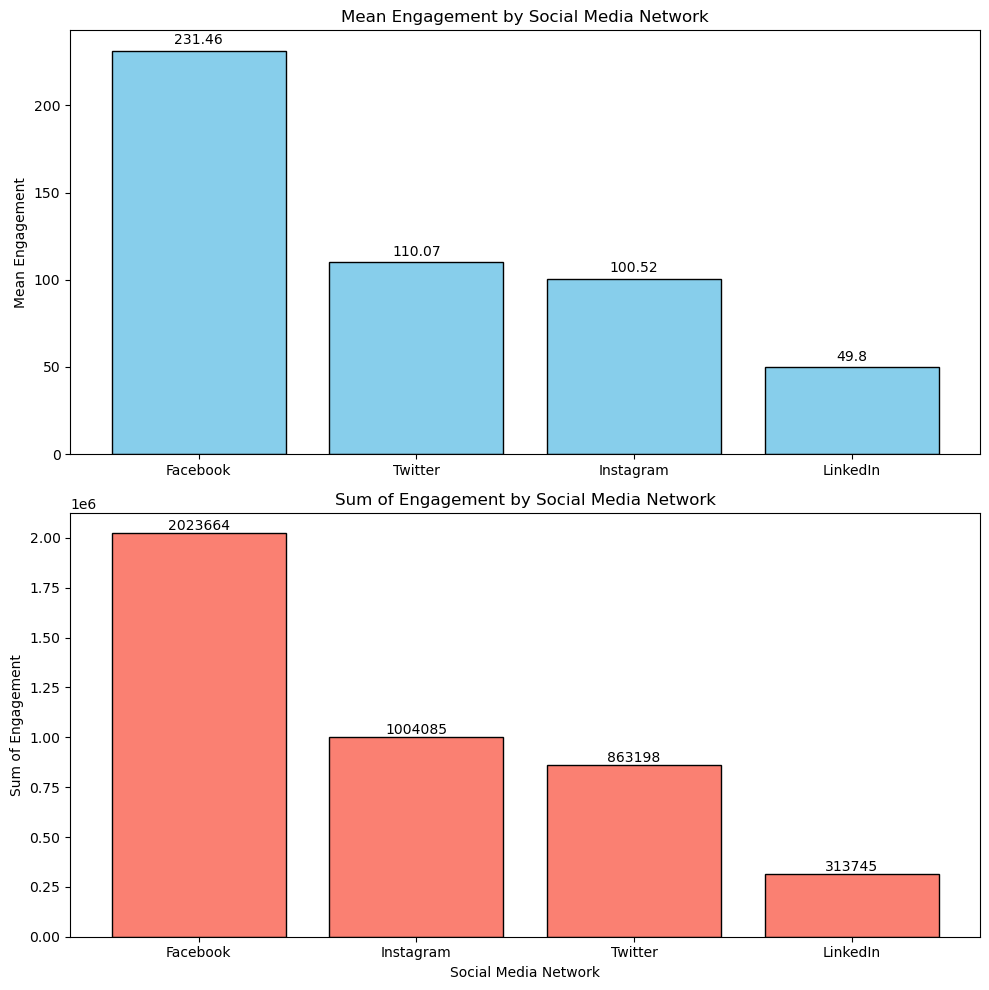

In [181]:
# Group by dominant_topic and compute mean and sum of engagement for each topic
grouped = data.groupby('Network')['Engagements'].agg(['mean', 'sum']).reset_index()

# Sort data by mean engagement for visual clarity
grouped_mean = grouped.sort_values(by='mean', ascending=False)
grouped_sum = grouped.sort_values(by='sum', ascending=False)

def annotate_bars(bars, ax):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting mean engagement
bars1 = axs[0].bar(grouped_mean['Network'].astype(str), grouped_mean['mean'], color='skyblue', edgecolor='black')
annotate_bars(bars1, axs[0])
axs[0].set_title('Mean Engagement by Social Media Network')
axs[0].set_ylabel('Mean Engagement')

# Plotting sum of engagement
bars2 = axs[1].bar(grouped_sum['Network'].astype(str), grouped_sum['sum'], color='salmon', edgecolor='black')
annotate_bars(bars2, axs[1])
axs[1].set_title('Sum of Engagement by Social Media Network')
axs[1].set_xlabel('Social Media Network')
axs[1].set_ylabel('Sum of Engagement')

plt.tight_layout()
plt.show()

**Observation**

* Facebook performs better in terms of engagement quality and Quantity

* Twitter has more Engagement Quality than Instagram, while Instagram has more Engagement Quantity Twitter.

* Linkeldn as the least for both.

## Topic Modelling

To implement topic modelling, it is important to follow this process:

* Clean the Text data

* Create bag of words (Converting the text to Number)

* Implement Latent Dirichlet Allocation

* Extract the Topic

* Findings and Conclusion

### Clean the Text data

In [182]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')

# load up a for wordnet
wnl = nltk.stem.WordNetLemmatizer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    document = re.sub('[0-9]+', '', document)
    document = re.sub(' +', ' ', document)
    document = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',document)
    document = re.sub(r'(.)1+', r'1', document)
    document = re.sub(r'http', r' ', document)
    document = re.sub(r'bank [a-z]\w+', r' ', document)
    
    # simple porter stemming
    document = ' '.join([wnl.lemmatize(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

clean_text = np.vectorize(simple_text_preprocessor)

In [183]:
### store the clean data to a new data frame
data['post_clean'] = clean_text(data['Post'].values)

In [184]:
data.head()

,Post,sentiment_label,Network,Engagements,post_clean
0,"We celebrated recently with Novare, one of our...",Positive sentiment,Facebook,1024,celebrated recently novare one top client th a...
1,N5k can get you started today. Call 01 280 126...,Neutral sentiment,Facebook,5876,n k get started today call email assetmanageme...
2,Still not sure whether to invest in the FGN Bo...,Negative sentiment,Facebook,4744,still sure whether invest fgn bond reason call...
3,Let nothing stop you from achieving your goals...,Positive sentiment,Facebook,445,let nothing stop achieving goal new week gofor...
4,"If you were to pick one wish, what would it be...",Positive sentiment,Facebook,4730,pick one wish would itcanbe


### Create bag of words (Converting the text to Number)

In [185]:
count = CountVectorizer(stop_words='english',max_df=.1,max_features=5000)

In [186]:
### fit the bag of words to the text
X = count.fit_transform(data['post_clean'].values)

### Implement Latent Dirichlet Allocation

we are interested in 10 different topics

In [187]:
lda = LatentDirichletAllocation(n_components=10,random_state=0,learning_method='online')

In [188]:
## fit the lda model
num_topics = lda.fit_transform(X)

In [189]:
lda.components_.shape

(10, 5000)

### Extract the Topic

In [190]:
n_top_words = 5 ## Top 5 words in each topics
feature_names = count.get_feature_names_out() ## get features name

In [191]:
for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {(topic_idx + 1)}:')
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1:
fund started child investment money
Topic 2:
business insurance life help plan
Topic 3:
bit ly click register link
Topic 4:
know love wealthwednesday number phone
Topic 5:
pension retirement smwlagos alimb work
Topic 6:
let better weekend woman answer
Topic 7:
card pay motivationmonday powerupmonday walk
Topic 8:
saving day account live reward
Topic 9:
year new happy goal season
Topic 10:
app download mobile goforit super


**Observation**

* Topic 1 - Post are focused on Investment of Money, and child fund.

* Topic 2 - Post are focused on Insurance and Planning.

* Topic 3 - Post are focused on Click and Registration link (Promotional Content).

* Topic 4 - Post are focused on Promotional post on financial well being

* Topic 5 - Post are focused on Financial planning and servings for workers, and pension for the retired workers enlightment

* Topic 6 - Post are focused on Weekend Content for customers.

* Topic 7 - Post are focused on Motivation, physical well being for customers.

* Topic 8 - Post are focused on savings encouragement, open account and reward.

* Topic 9 - Post are focused on New year celebration and goals planning

* Topic 10 - Post are focused on bank promotion of mobile banking and ease for customers.

In [192]:
# Predict the topic for each text
topic_probabilities = lda.transform(X)
data['dominant_topic'] = topic_probabilities.argmax(axis=1)

In [193]:
## Make it to be from 1 - 10 topics instead of (0-9 python index)
data['dominant_topic'] = data['dominant_topic'] + 1

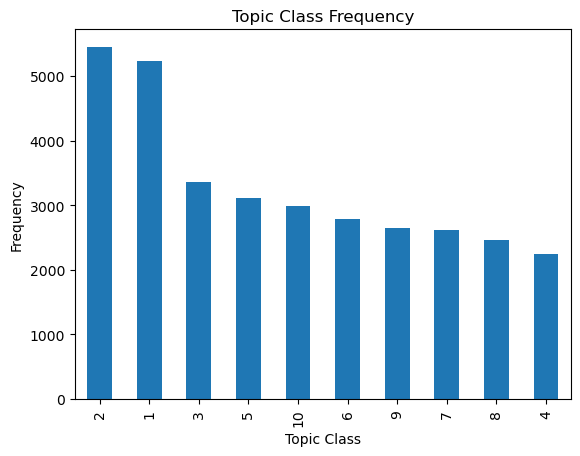

In [194]:
plt.title('Topic Class Frequency')
data['dominant_topic'].value_counts().plot(kind='bar');
plt.xlabel('Topic Class');
plt.ylabel('Frequency');

**Observation**

* Most Post of the banks belongs to Topic 2 and Topic 1

* Topic 4 has the least post.

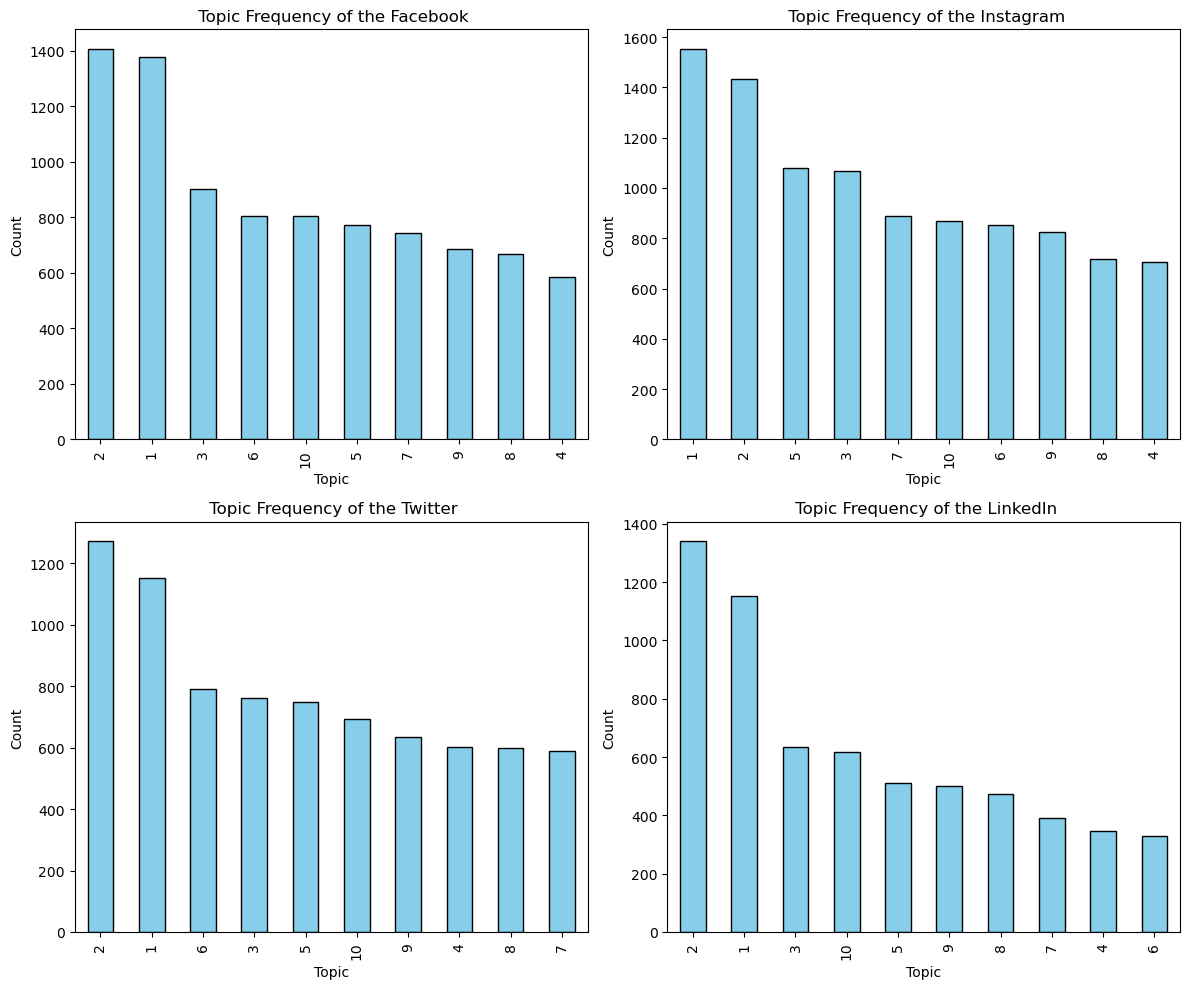

In [195]:
networks = list(data['Network'].unique())

plt.figure(figsize=(12, 10))

for index, network in enumerate(networks, 1):
    plt.subplot(2, 2, index)  # 2x2 grid
    topic_counts = data[data['Network'] == network]['dominant_topic'].value_counts()
    
    # Plot bar chart
    topic_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f" Topic Frequency of the {network}")
    plt.xlabel('Topic')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

**Observation**

* Facebook, and Linkedln most dominant topics are Topic 2, 1 and 3 in order.

* Twitter most dominant topics are Topic 2, 1, 6 in order.

* Instagram most dominant topics are Topic 1, 2, 5 in order.

### Quantity and Quality of dominated Topics by Engagements

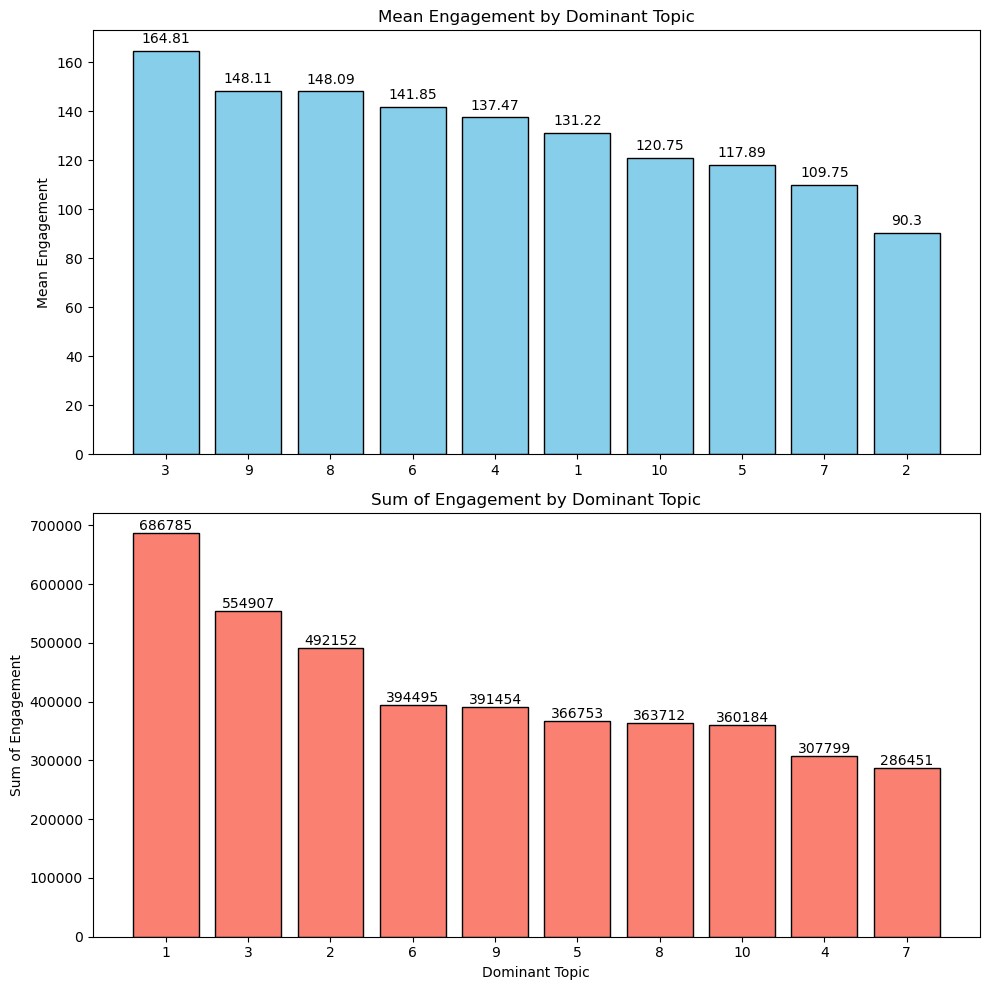

In [196]:
# Group by dominant_topic and compute mean and sum of engagement for each topic
grouped = data.groupby('dominant_topic')['Engagements'].agg(['mean', 'sum']).reset_index()

# Sort data by mean engagement for visual clarity
grouped_mean = grouped.sort_values(by='mean', ascending=False)
grouped_sum = grouped.sort_values(by='sum', ascending=False)

def annotate_bars(bars, ax):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting mean engagement
bars1 = axs[0].bar(grouped_mean['dominant_topic'].astype(str), grouped_mean['mean'], color='skyblue', edgecolor='black')
annotate_bars(bars1, axs[0])
axs[0].set_title('Mean Engagement by Dominant Topic')
axs[0].set_ylabel('Mean Engagement')

# Plotting sum of engagement
bars2 = axs[1].bar(grouped_sum['dominant_topic'].astype(str), grouped_sum['sum'], color='salmon', edgecolor='black')
annotate_bars(bars2, axs[1])
axs[1].set_title('Sum of Engagement by Dominant Topic')
axs[1].set_xlabel('Dominant Topic')
axs[1].set_ylabel('Sum of Engagement')

plt.tight_layout()
plt.show()

## Sentiment Analysis Model

1. Analyze most common words in the data

2. Visualize common words for each sentiment

3. Split the data and Feature extraction

4. Machine Learning Models

5. Evaluation

6. Interpretable Machine Learning

7. Conclusion.

 #### Analyze most common words in the data

In [197]:
data['temp_list'] = data['post_clean'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,itcanbe,13837
1,co,8621
2,get,7031
3,stanbicibtc,7012
4,stanbic,6400
5,ibtc,6358
6,com,5254
7,u,5221
8,visit,4865
9,email,4313


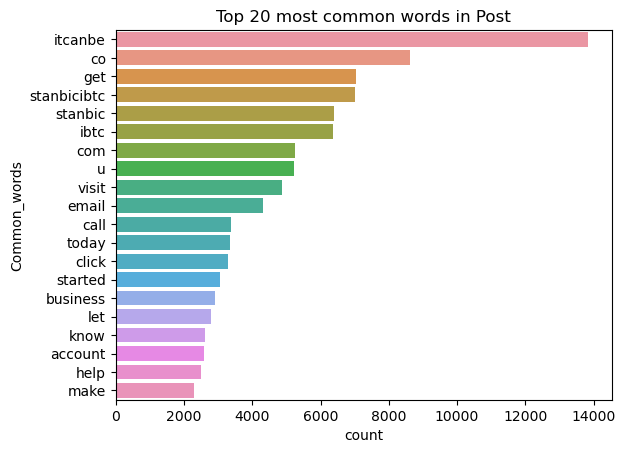

In [198]:
plt.title('Top 20 most common words in Post')
sns.barplot(temp, x="count", y="Common_words");

**Observation**

* The most common words is the #itcanbe

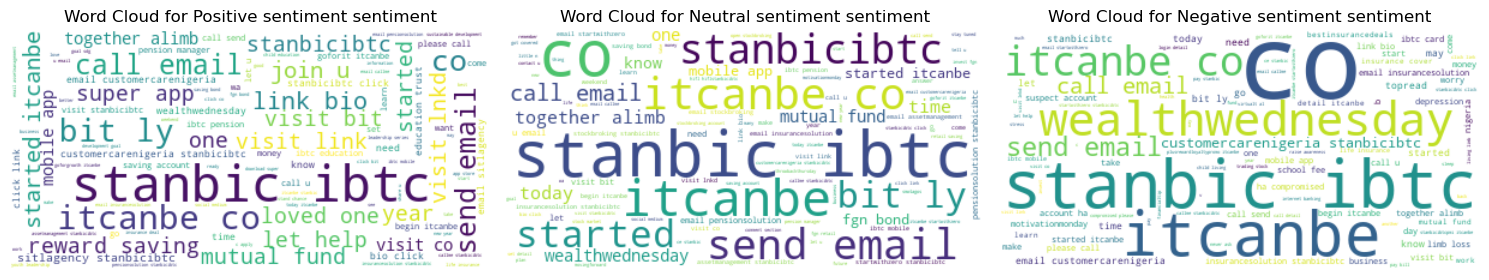

In [199]:
# Define sentiment types (assuming three basic sentiments here)
sentiments = list(data['sentiment_label'].unique())

plt.figure(figsize=(15, 5))

for index, sentiment in enumerate(sentiments, 1):
    # Filter texts by sentiment
    sentiment_texts = data[data['sentiment_label'] == sentiment]['post_clean'].str.cat(sep=' ').lower()
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white', max_words=100).generate(sentiment_texts)
    
    # Plot the word cloud
    plt.subplot(1, 3, index)  # Adjust the numbers (1, 3) based on the number of sentiment types
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} sentiment')

plt.tight_layout()
plt.show()

**Observation**

* The sentiment of each post can not be known in a human readble format, this is while a **Machine Learning Model** is very important.

#### Data Spliting and Feature Extraction

In [200]:
### select the post and sentiment label
sen_data = data[['post_clean', 'sentiment_label']]

In [201]:
sen_data['sentiment_label'].value_counts(normalize=True)

Positive sentiment    0.723490
Neutral sentiment     0.200614
Negative sentiment    0.075896
Name: sentiment_label, dtype: float64

In [202]:
map_sentiment = {'Positive sentiment':2, 'Neutral sentiment':1, 'Negative sentiment':0}

In [203]:
## Transform the sentiment label to number
sen_data['sentiment_label'] = sen_data['sentiment_label'].map(map_sentiment)

In [204]:
X=sen_data.drop('sentiment_label', axis=1)
y=sen_data['sentiment_label']

In [205]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =2023, stratify=y)

In [206]:
print('Shape of the X_train {}'.format(X_train.shape))
print('Shape of the y_train {}'.format(y_train.shape))
print('Shape of the X_test {}'.format(X_test.shape))
print('Shape of the y_test {}'.format(y_test.shape))

Shape of the X_train (26299, 1)
Shape of the y_train (26299,)
Shape of the X_test (6575, 1)
Shape of the y_test (6575,)


In [207]:
tvidf = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2), analyzer='word', max_features=250) #'char'

In [208]:
tfidf = tvidf.fit(X_train['post_clean']) # fitting on the train

In [209]:
train_tfidf = tfidf.transform(X_train['post_clean']).toarray()
train_tfidf = pd.DataFrame(train_tfidf ,columns=tvidf.get_feature_names())

In [210]:
test_tfidf = tfidf.transform(X_test['post_clean']).toarray()
test_tfidf = pd.DataFrame(test_tfidf ,columns=tvidf.get_feature_names())

In [211]:
print(f" The shape of transform train data {train_tfidf.shape}")
print(f" The shape of transform test data {test_tfidf.shape}")

 The shape of transform train data (26299, 250)
 The shape of transform test data (6575, 250)


### Machine Learning Models

Research novelty is that there is no one models for all problems, i.e No free Lunch theorem

Therefore, we are going to test some bunch of machine learning models

In [212]:
algos = [LogisticRegression(), 
        RandomForestClassifier(max_depth=5,n_estimators=1000, max_features='auto', class_weight='balanced'),
        ExtraTreeClassifier(class_weight='balanced', random_state=101),
        CatBoostClassifier(logging_level='Silent'),
         XGBClassifier(max_depth=4, n_estimators=500)]

names = ['Logistic_Regression',  'RandomForest','ExtraTree', 'CatBoost', 'Xgboost']
accuracy_list = []

In [213]:
for name in algos:
    model = name
    model.fit(train_tfidf,y_train)
    y_pred = model.predict(test_tfidf)
    accuracy= accuracy_score(y_test,y_pred)
    accuracy_list.append(accuracy)

In [214]:
evaluation = pd.DataFrame({'Model': names,
                           'Accuracy_Score': accuracy_list})

In [215]:
evaluation = evaluation.sort_values(by='Accuracy_Score', ascending=False).reset_index(drop=True)

In [216]:
evaluation['Accuracy_Score'] = evaluation['Accuracy_Score'].round(2)

In [217]:
evaluation

,Model,Accuracy_Score
0,ExtraTree,0.85
1,Xgboost,0.84
2,CatBoost,0.79
3,Logistic_Regression,0.76
4,RandomForest,0.63


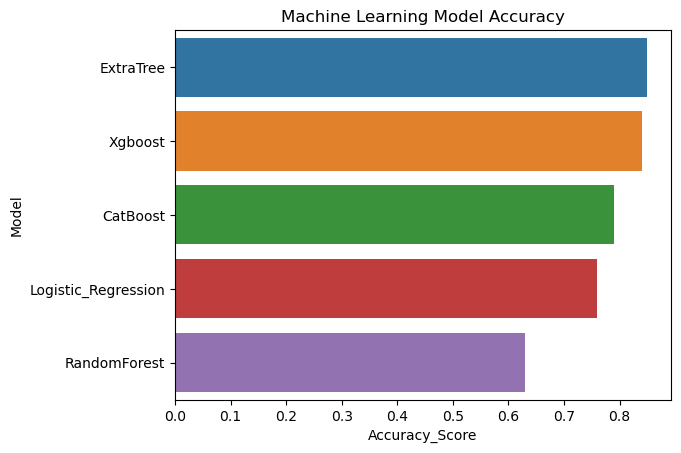

In [227]:
plt.title('Machine Learning Model Accuracy')
sns.barplot(data=evaluation,y='Model', x='Accuracy_Score');
plt.savefig('ml.png')

**Observation**

* Extra Tree Classifier is the most accurate model, which will be able to classify our post sentiment correct with 85% assurance.


### Model Inference using Extra Tree

In [219]:
model = algos[2]

In [220]:
model

ExtraTreeClassifier(class_weight='balanced', random_state=101)

In [221]:
# Predict a new text, The new test data is Stanbic IBTC post on Tuesday 03/10/2023
new_post = ["Unlock the path to swift financial assistance with our hassle-free EZ Cash. Everything you need is just a few clicks away!"]
new_text_transformed = tvidf.transform(new_post)
prediction = model.predict(new_text_transformed)

In [222]:
# Interpretation for three classes
if prediction[0] == 0:
    print("Prediction for new text: Negative")
elif prediction[0] == 1:
    print("Prediction for new text: Neutral")
else:
    print("Prediction for new text: Positive")

Prediction for new text: Positive


### Interpretable Machine Learning

1. What drives model predictions? […] This ensures fairness of the model.

2. Why did the model take a certain decision? […] This ensures accountability and reliability of the model.

3. How can we trust model predictions? […] This ensures transparency of the model.

In [223]:
feature_names = tfidf.get_feature_names_out()
explainer = shap.Explainer(model, train_tfidf, feature_names=feature_names)
shap_values = explainer(test_tfidf)
print(shap_values.values.shape)  # (6575, 250, 3)

 95%|=================== | 18822/19725 [00:17<00:00]       

(6575, 250, 3)


### Feature Importance for Each Class

### Positive Class

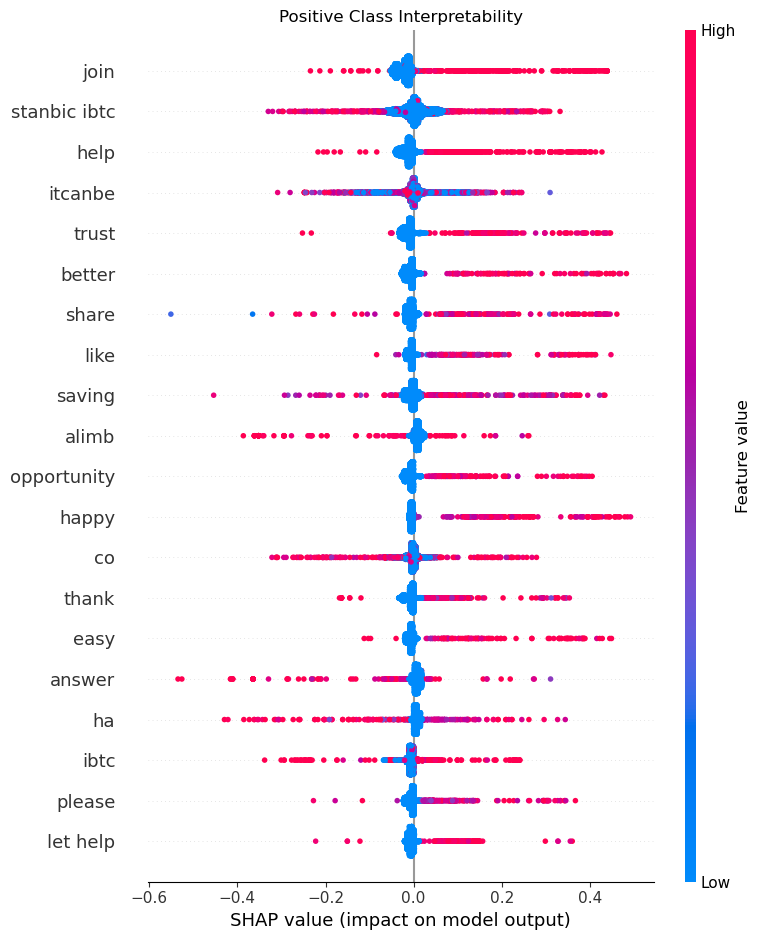

In [224]:
plt.title('Positive Class Interpretability')
shap.summary_plot(shap_values[:,:, 2].values, test_tfidf, feature_names=feature_names, title="Class 2")

### Neutral Class

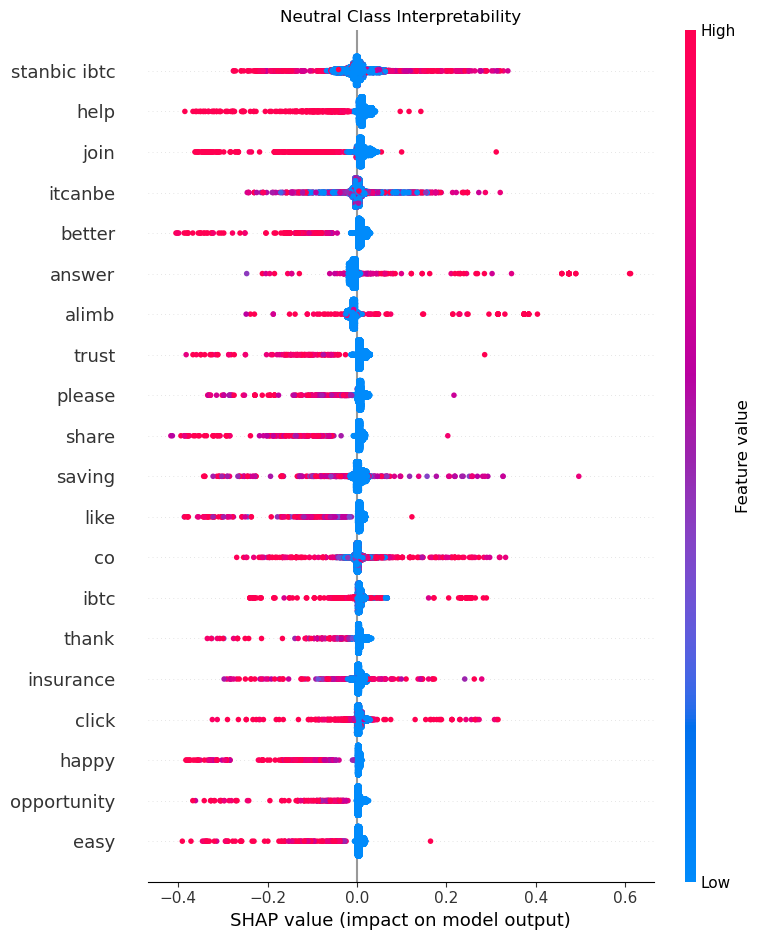

In [225]:
plt.title('Neutral Class Interpretability')
shap.summary_plot(shap_values[:,:, 1].values, test_tfidf, feature_names=feature_names, title="Class 1")

### Negative Class

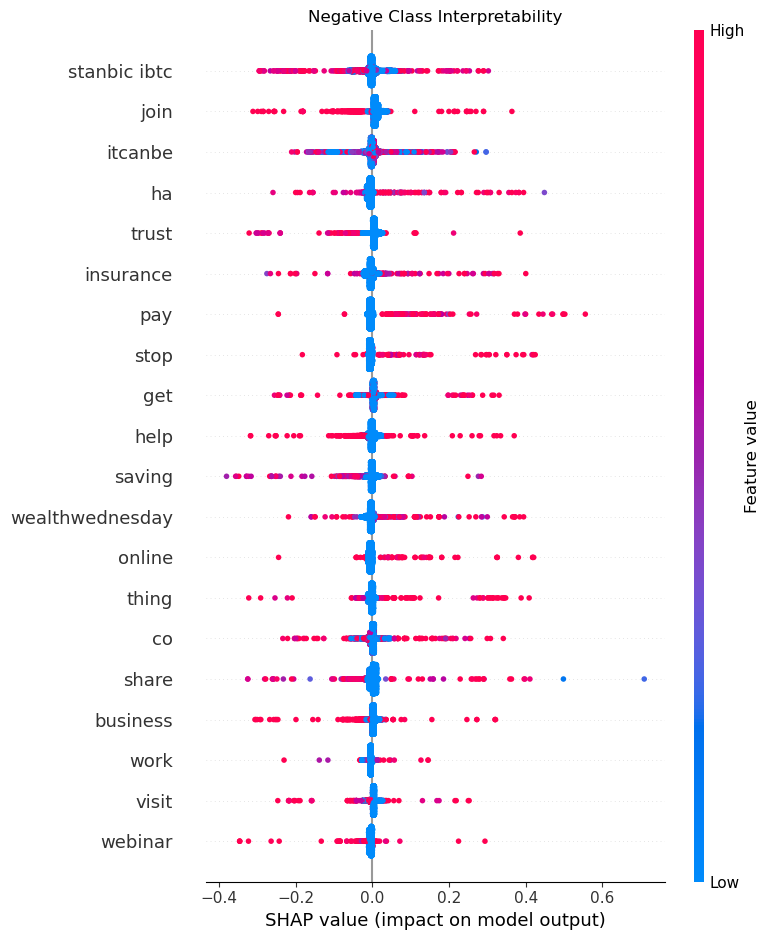

In [226]:
plt.title('Negative Class Interpretability')
shap.summary_plot(shap_values[:,:, 0].values, test_tfidf, feature_names=feature_names, title="Class 0")